# Library

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic') 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier, Pool

In [4]:
from tqdm.notebook import tqdm

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [6]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


# preprocessing

In [8]:
cond_loan_term_36 = (train['대출기간']==' 36 months')

train.loc[cond_loan_term_36, '대출기간'] = '36M'
train.loc[~cond_loan_term_36, '대출기간'] = '60M'

cond_loan_term_36 = (test['대출기간']==' 36 months')

test.loc[cond_loan_term_36, '대출기간'] = '36M'
test.loc[~cond_loan_term_36, '대출기간'] = '60M'

train['대출기간'] = train['대출기간'].str.split('M').apply(lambda x: int(x[0]))
test['대출기간'] = test['대출기간'].str.split('M').apply(lambda x: int(x[0]))

In [9]:
# Longer 10Y
cond_employ_dur_10Y_1 = (train['근로기간']=='10+ years')
cond_employ_dur_10Y_2 = (train['근로기간']=='10+years')

train.loc[cond_employ_dur_10Y_1, '근로기간'] = '10 years'
train.loc[cond_employ_dur_10Y_2, '근로기간'] = '10 years'

cond_employ_dur_10Y_1 = (test['근로기간']=='10+ years')
cond_employ_dur_10Y_2 = (test['근로기간']=='10+years')

test.loc[cond_employ_dur_10Y_1, '근로기간'] = '10 years'
test.loc[cond_employ_dur_10Y_2, '근로기간'] = '10 years'

# 3Y
cond_employ_dur_3Y = (train['근로기간']=='3')
train.loc[cond_employ_dur_3Y, '근로기간'] = '3 years'
cond_employ_dur_3Y = (test['근로기간']=='3')
test.loc[cond_employ_dur_3Y, '근로기간'] = '3 years'

# 1Y
cond_employ_dur_1Y_1 = (train['근로기간']=='1 year')
train.loc[cond_employ_dur_1Y_1, '근로기간'] = '1 years'
cond_employ_dur_1Y_1 = (test['근로기간']=='1 year')
test.loc[cond_employ_dur_1Y_1, '근로기간'] = '1 years'

# Shorter 1Y
cond_employ_dur_down_1Y_1 = (train['근로기간']=='< 1 year')
cond_employ_dur_down_1Y_2 = (train['근로기간']=='<1 year')

train.loc[cond_employ_dur_down_1Y_1, '근로기간'] = '0 years'
train.loc[cond_employ_dur_down_1Y_2, '근로기간'] = '0 years'

cond_employ_dur_down_1Y_1 = (test['근로기간']=='< 1 year')
cond_employ_dur_down_1Y_2 = (test['근로기간']=='<1 year')

test.loc[cond_employ_dur_down_1Y_1, '근로기간'] = '0 years'
test.loc[cond_employ_dur_down_1Y_2, '근로기간'] = '0 years'

# Unknown
cond_unknown = (train['근로기간'] == 'Unknown')
train.loc[cond_unknown, '근로기간'] = '999 years'

cond_unknown = (test['근로기간'] == 'Unknown')
test.loc[cond_unknown, '근로기간'] = '999 years'

train['근로기간'] = train['근로기간'].str.split(' ').apply(lambda x: int(x[0]))
test['근로기간'] = test['근로기간'].str.split(' ').apply(lambda x: int(x[0]))

In [10]:
cond_long = (train['근로기간']<=10) & (train['근로기간']>6) 
train.loc[cond_long, '근속기간'] = '장기'

cond_middle = (train['근로기간']<=6) & (train['근로기간']>3)
train.loc[cond_middle, '근속기간'] = '중기'

cond_short = (train['근로기간']<=3) & (train['근로기간']>=1)
train.loc[cond_short, '근속기간'] = '단기'

cond_intern = (train['근로기간']==0)
train.loc[cond_intern, '근속기간'] = '인턴'

cond_nan = (train['근로기간']==999)
train.loc[cond_nan, '근속기간'] = '결측치'

cond_long = (test['근로기간']<=10) & (test['근로기간']>6) 
test.loc[cond_long, '근속기간'] = '장기'

cond_middle = (test['근로기간']<=6) & (test['근로기간']>3)
test.loc[cond_middle, '근속기간'] = '중기'

cond_short = (test['근로기간']<=3) & (test['근로기간']>=1)
test.loc[cond_short, '근속기간'] = '단기'

cond_intern = (test['근로기간']==0)
test.loc[cond_intern, '근속기간'] = '인턴'

cond_nan = (test['근로기간']==999)
test.loc[cond_nan, '근속기간'] = '결측치'

train.drop(columns=['근로기간'], inplace=True)
test.drop(columns=['근로기간'], inplace=True)

In [11]:
train['근사이자율'] = (train['총상환이자'] / train['대출기간']) / train['총상환원금'] * 100
test['근사이자율'] = (test['총상환이자'] / test['대출기간']) / test['총상환원금'] * 100

train['역근사이자율'] = (train['총상환원금']) / (train['총상환이자'] / train['대출기간']) * 100
test['역근사이자율'] = (test['총상환원금']) / (test['총상환이자'] / test['대출기간']) * 100

print(train[['근사이자율']].isnull().sum())

train['대출기간'] = train['대출기간'].astype('object')
test['대출기간'] = test['대출기간'].astype('object')

근사이자율    5407
dtype: int64


In [12]:
train['대출금_대비_총상환이자'] =  train['총상환이자'] / train['대출금액']
test['대출금_대비_총상환이자'] =  test['총상환이자'] / test['대출금액'] 

train['대출금_대비_총상환원금'] =  train['총상환원금'] / train['대출금액']
test['대출금_대비_총상환원금'] =  test['총상환원금'] / test['대출금액'] 

In [13]:
train['소득_대비_대출금'] = train['연간소득'] / train['대출금액'] 
test['소득_대비_대출금'] = test['연간소득'] / test['대출금액'] 

In [14]:
train['소득_대비_부채_비율'] = ((train['총상환원금']+train['총상환이자'])/12)/(train['연간소득']/12)*100
test['소득_대비_부채_비율'] = ((test['총상환원금']+test['총상환이자'])/12)/(test['연간소득']/12)*100

In [15]:
cond = (train['연체계좌수']==0) & (train['총연체금액']==0)
train.loc[cond, '연체여부'] = 0
train.loc[~cond, '연체여부'] = 1

cond = (test['연체계좌수']==0) & (test['총연체금액']==0)
test.loc[cond, '연체여부'] = 0
test.loc[~cond, '연체여부'] = 1

train['연체여부'] = train['연체여부'].astype('object')
test['연체여부'] = test['연체여부'].astype('object')

In [16]:
cond_home = (train['대출목적']=='이사') | (train['대출목적']=='재생 에너지') | (train['대출목적']=='주택') | (train['대출목적']=='주택 개선')
train.loc[cond_home, '대출목적'] = 'home'

cond_dept = (train['대출목적']== '부채 통합')
train.loc[cond_dept, '대출목적'] = 'dept'

cond_fin = (train['대출목적']=='신용 카드')
train.loc[cond_fin, '대출목적'] = 'fin'

cond_buy =  (train['대출목적']== '주요 구매') | (train['대출목적']=='휴가') | (train['대출목적']=='의료') | (train['대출목적']=='자동차') |  (train['대출목적'] == '기타')
train.loc[cond_buy, '대출목적'] = 'buy'

cond_busin = (train['대출목적']=='소규모 사업')
train.loc[cond_busin, '대출목적'] = 'business'

cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy
train.loc[~cond_all, '대출목적'] = 'buy'

cond_home = (test['대출목적']=='이사') | (test['대출목적']=='재생 에너지') | (test['대출목적']=='주택') | (test['대출목적']=='주택 개선')
test.loc[cond_home, '대출목적'] = 'home'

cond_dept = (test['대출목적']== '부채 통합')
test.loc[cond_dept, '대출목적'] = 'dept'

cond_fin = (test['대출목적']=='신용 카드')
test.loc[cond_fin, '대출목적'] = 'fin'

cond_buy =  (test['대출목적']== '주요 구매') | (test['대출목적']=='휴가') | (test['대출목적']=='의료') | (test['대출목적']=='자동차') | (test['대출목적'] == '기타')
test.loc[cond_buy, '대출목적'] = 'buy'

cond_busin = (test['대출목적']=='소규모 사업')
test.loc[cond_busin, '대출목적'] = 'business'

cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy
test.loc[~cond_all, '대출목적'] = 'buy'

In [17]:
train.loc[(train['대출등급']=='G')]

,ID,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,...,연체계좌수,대출등급,근속기간,근사이자율,역근사이자율,대출금_대비_총상환이자,대출금_대비_총상환원금,소득_대비_대출금,소득_대비_부채_비율,연체여부
24,TRAIN_00024,20670000,60,RENT,61200000,20.33,36,buy,0,527244,...,0.0,G,장기,4.085433,2447.721005,0.062526,0.025508,2.960813,2.973294,0.0
92,TRAIN_00092,32280000,60,MORTGAGE,84960000,28.59,27,dept,1,257040,...,0.0,G,결측치,4.445923,2249.251824,0.021241,0.007963,2.631970,1.109590,0.0
161,TRAIN_00161,30240000,60,RENT,72000000,29.32,15,buy,0,244632,...,0.0,G,단기,3.983207,2510.539603,0.019334,0.008090,2.380952,1.151783,0.0
695,TRAIN_00695,16020000,60,MORTGAGE,63600000,19.13,19,home,0,510636,...,0.0,G,장기,4.741891,2108.863541,0.090688,0.031875,3.970037,3.087208,0.0
718,TRAIN_00718,38670000,60,MORTGAGE,102000000,20.73,46,dept,0,1329384,...,0.0,G,단기,4.047092,2470.909679,0.083478,0.034378,2.637704,4.468106,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94294,TRAIN_94294,17130000,60,MORTGAGE,50400000,21.23,25,buy,0,398892,...,0.0,G,장기,4.917120,2033.710615,0.068701,0.023286,2.942207,3.126452,0.0
94324,TRAIN_94324,29100000,60,MORTGAGE,76800000,18.24,32,fin,0,711108,...,0.0,G,단기,4.515742,2214.475676,0.066210,0.024437,2.639175,3.434656,0.0
94543,TRAIN_94543,42000000,60,RENT,114000000,10.30,12,dept,0,665388,...,0.0,G,중기,5.032192,1987.205677,0.047834,0.015843,2.714286,2.345968,0.0
95477,TRAIN_95477,30000000,60,MORTGAGE,120000000,18.05,14,dept,0,490824,...,0.0,G,단기,4.299423,2325.893492,0.042205,0.016361,4.000000,1.464150,0.0


In [18]:
def credits_level_counts(col):

    unique_list = list(train[col].unique())
    
    for unique in unique_list:
    
        cond_unique = (train[col]==unique)
        print(unique)
        print(train.loc[cond_unique]['대출등급'].value_counts())
        print()

hue_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [19]:
def num_statistic(data, col):
    statistic_df = pd.DataFrame()

    for level in hue_order:
        level_df = data.loc[(data['대출등급']==level)][[col]].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        level_df.index = [level]
        
        statistic_df = pd.concat([statistic_df, level_df], axis=0)

    display(statistic_df)
    print()

In [20]:
train['연체대비소득'] = train['총연체금액'] / train['연간소득']
cond = (train['총연체금액']==0)
train.loc[cond, '연체대비소득'] = np.nan

In [21]:
cond = (train['총연체금액']==0)
train.loc[cond, '총연체금액'] = np.nan

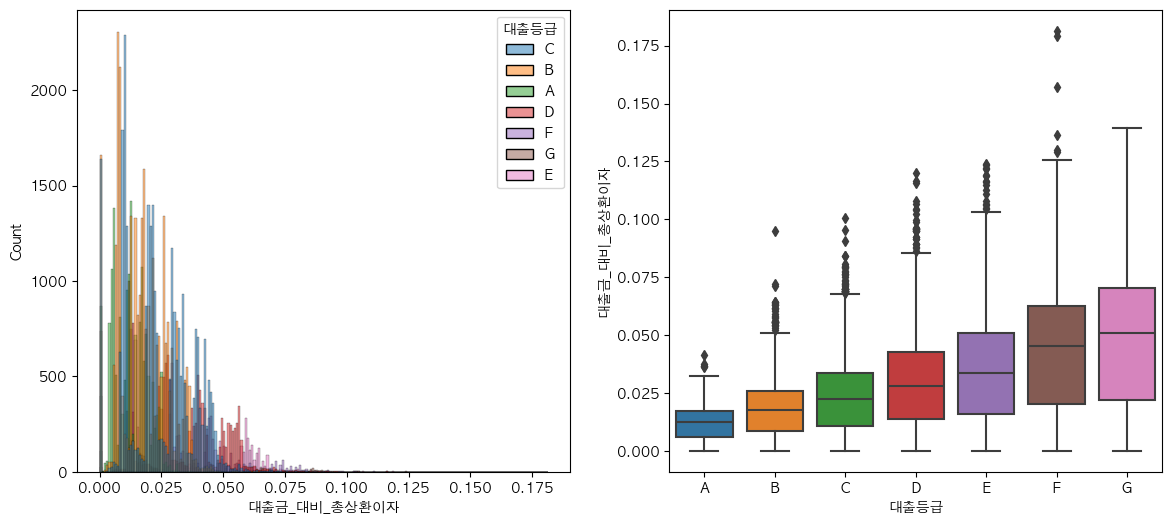

,mean,std,min,25%,50%,75%,max
A,0.012414,0.006792,0.0,0.006137,0.012219,0.017293,0.041269
B,0.017697,0.009932,0.0,0.008547,0.017490,0.025604,0.094911
C,0.023874,0.013314,0.0,0.010632,0.022154,0.033634,0.100353
D,0.031217,0.017358,0.0,0.013666,0.028153,0.042706,0.120203
E,0.036467,0.019927,0.0,0.015743,0.033647,0.050804,0.123920
F,0.045236,0.025082,0.0,0.020027,0.045168,0.062477,0.181466
G,0.052082,0.028765,0.0,0.022041,0.051010,0.070512,0.139385


In [22]:
col = '대출금_대비_총상환이자'
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train, x=col, hue='대출등급', ax=ax[0])
sns.boxplot(data=train, y=col, x='대출등급', order=hue_order, ax=ax[1])
plt.show()
num_statistic(train, col)

In [ ]:
train['연체대비대출'] = train['총연체금액'] / train['대출금액']
cond = (train['총연체금액']==0)
train.loc[cond, '연체대비대출'] = np.nan

In [ ]:
col = '연간소득'
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train, x=col, hue='대출등급', ax=ax[0])
sns.boxplot(data=train, y=col, x='대출등급', order=hue_order, ax=ax[1])
plt.show()
num_statistic(train, col)

In [ ]:
col = '근사이자율'
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train, x=col, hue='대출등급', ax=ax[0])
sns.boxplot(data=train, y=col, x='대출등급', order=hue_order, ax=ax[1])
plt.show()
num_statistic(train, col)

In [ ]:
cond = (train['총상환이자']==0)
train.loc[cond].shape[0]

In [ ]:
cond = (train['총연체금액']==0)  & (train['연체계좌수']==0) & (train['최근_2년간_연체_횟수']==0)
train.loc[cond].shape[0]

In [ ]:
col = '연체대비소득'
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train, x=col, hue='대출등급', ax=ax[0])
sns.boxplot(data=train, y=col, x='대출등급', order=hue_order, ax=ax[1])
plt.show()
num_statistic(train, col)

In [ ]:
cond = (train['연간소득']<=50400000.0) & (train['근사이자율']>=4.615506)
train.loc[cond][['연간소득', '대출등급']]

In [ ]:
col='연체대비소득'
num_statistic(train, col)

In [ ]:
col='근사이자율'
num_statistic(train, col)

In [ ]:
train['대출등급'].value_counts()

In [ ]:
cond = (train['연간소득']<=50400000.0) & (train['근사이자율']>=4.615506)
train.loc[cond]['대출등급'].value_counts()